# Решение ОДУ на Julia для робототехники

Сегодня будем исследовать робототехнику с позиции ОДУ. ОДУ там буквально везде: это и управление (см. системное управление, управляющее воздействие), и расчёт динамики робота (то, как ему двигаться), и моделирование работы робота в физической среде. Использование корректных методов решения ОДУ очень важно в этих задачах для обеспечения тех или иных целей (время реакции, точность реакции или адекватность модели, например.) *тут может быть [видео](https://vkvideo.ru/video-49770594_171647393) (или его [оригинал](https://www.youtube.com/watch?v=E2evC2xTNWg)), где робо-рука крушит половину кухни, пока готовит завтрак*

Для этой задачи мы попробуем использовать язык программирования Julia, который содержит большое количество пакетов для математики и анализа данных. Особенно богата у Julia библиотека для решения дифференциальных уравнений DifferentialEquations. Среди её зависимостей мы можем заметить уже знакомые нам, как например Sundials.

На практике для робототехники используют разные инструменты. В разных случаях популярны и С/С++, и Python, и Matlab и другие решения. Julia также является весьма современным и актуальным подходом. В конце ноутбука можно будет найти ссылки на некоторые дополнительные ресурсы по этой теме.



**Learning Objectives:**
- Learn how to set up a robotics simulation using ODE models in Julia.
- Experiment with different ODE solvers (e.g., Tsit5, Rodas5, CVODE_BDF) and see how they differ in handling non‑stiff and stiff systems.
- Understand the impact of solver choice on accuracy, stability, and execution time.

This notebook is designed to run on Binder
[Binder Link](https://mybinder.org/).

In [13]:
##############################
# Package Setup
##############################

using Pkg
# If running for the first time on Binder, uncomment the following lines:
# Pkg.add("DifferentialEquations")
# Pkg.add("Plots")
# Pkg.add("MeshCat")
# Pkg.add("RigidBodyDynamics")
# Pkg.add("IJulia")
# Pkg.add("ModelingToolkit")

# Pkg.resolve()

# using IJulia
# notebook()

using DifferentialEquations
using Plots
using Sundials

# Set a default plot theme
default(; lw=2, size=(600,400))

## 1. Робототехника

В робототехнике распространенной простой моделью является **двойной интегратор**, который может представлять линейное движение робота. Вектор состояния определяется как:

- **u[1]:** Позиция (position)
- **u[2]:** Скорость (velocity)

Динамика задаётся следующим уравнением:

- $$ \frac{d}{dt} (\text{position}) = \text{velocity} $$
- $$ \frac{d}{dt} (\text{velocity}) = -k \times (\text{position}) - c \times (\text{velocity}) $$

где $k$ - коэффициент упругости, а $c$ - коэффициент затухания. Эта простая модель позволит нам исследовать поведение как нежестких, так и жестких материалов, регулируя параметры.

In [14]:
##############################
# Define the ODE Model
##############################

# The robot dynamics function for the double integrator
function robot_dynamics!(du, u, p, t)
    # u[1] = position, u[2] = velocity
    du[1] = u[2]                           # d(position)/dt = velocity
    du[2] = -p[1]*u[1] - p[2]*u[2]           # acceleration = -k*position - c*velocity
end

# Initial conditions: robot starts at position 1.0 with zero initial velocity
u0 = [1.0, 0.0]

# Time span for the simulation: 0 to 10 seconds
tspan = (0.0, 10.0)

# Parameters: p = [spring constant, damping coefficient]
p = [2.0, 0.5]

# Create the ODE problem
prob = ODEProblem(robot_dynamics!, u0, tspan, p)


ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: 2-element Vector{Float64}:
 1.0
 0.0

## 2. Решение задачи Коши (ОДУ) разными методами

Библиотека DifferentialEquations.jl предлагает широкий выбор реализаций методов решения дифференциальных уравнений. Давайте рассмотрим как можно решить уравнение для двойного инегратора при помощи этих методов и сравним результаты. Можно свериться с [Документацией DifferentialEquations.jl](https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/) для дополнительных деталей.

Для начала будем использовать следующие методы:

- **Tsit5**: не жёсткий, явный метод Рунге-Кутты
- **Rodas5**: неявный метод, который потенциально подходит для жёстких систем
- **CVODE_BDF**: метод из библиотеки Sundials (часто используется для больших жёстких систем)

Не стесняйтесь настраивать параметры (например, увеличивать коэффициент затухания), чтобы увидеть, как методы реагируют на более жёсткую динамику.

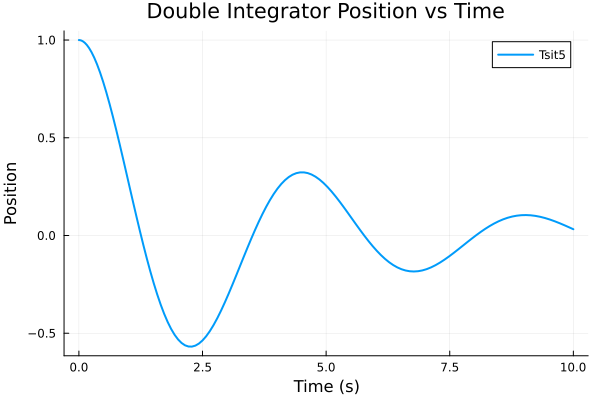

In [15]:
##############################
# Solve using Tsit5 (non-stiff)
##############################

sol_Tsit5 = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)

plot(sol_Tsit5.t, sol_Tsit5[1,:], label="Tsit5", xlabel="Time (s)", ylabel="Position", 
     title="Double Integrator Position vs Time", lw=2)
display(current())


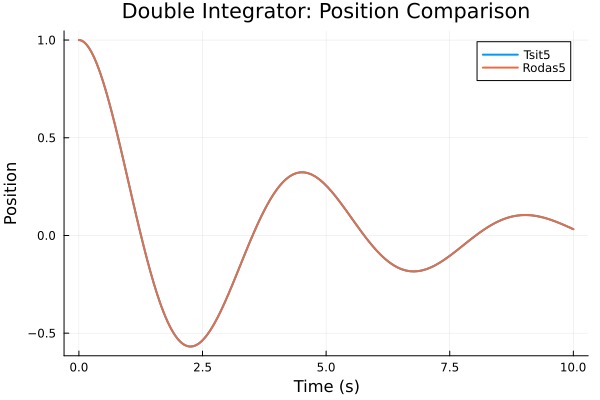

In [16]:
##############################
# Solve using Rodas5 (for stiff systems)
##############################

sol_Rodas5 = solve(prob, Rodas5(), reltol=1e-8, abstol=1e-8)

# Plotting on the same figure for comparison
plot(sol_Tsit5.t, sol_Tsit5[1,:], label="Tsit5", xlabel="Time (s)", ylabel="Position", 
     title="Double Integrator: Position Comparison", lw=2)
plot!(sol_Rodas5.t, sol_Rodas5[1,:], label="Rodas5", lw=2)
display(current())


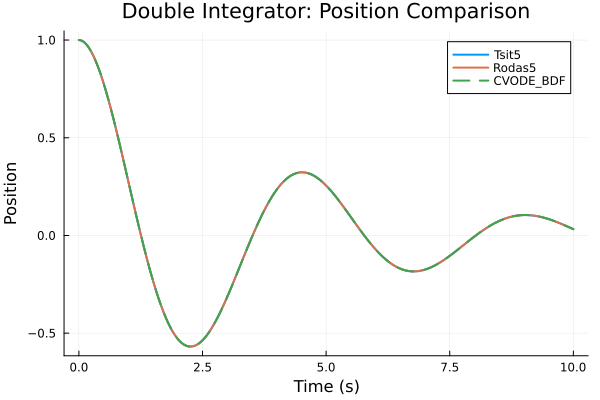

In [17]:
##############################
# Solve using CVODE_BDF (from Sundials, for stiff problems)
##############################

sol_CVODE = solve(prob, CVODE_BDF(), reltol=1e-8, abstol=1e-8)

# Add the solution from CVODE_BDF on our comparison plot
plot!(sol_CVODE.t, sol_CVODE[1,:], label="CVODE_BDF", linestyle=:dash, lw=2)
display(current())


## 3. Экспериментирование и анализ

Теперь ваша очередь экспериментировать! Попробуйте выполнить следующие задания:

1. **Добавление решателя:** Добавьте метод Эйлера из библиотеки DifferentialEquations.jl аналогично остальным методам.

2. **Измените параметры:** Увеличьте коэффициент затухания (или коэффициент упругости), чтобы повысить жёсткость модели. Обратите внимание на то, как меняются решения и как некоторые решатели справляются с жёсткой динамикой лучше, чем другие.

3. **Погрешности метода:** Измените относительную (`reltol`) и абсолютную (`abstol`) погрешность при вызове метода `solve()`. Следите за изменениями точности и времени вычислений.

4. **Анализ времени работы:** Используйте макрос "@time", чтобы измерить, сколько времени занимает каждое решение. Например:

   ```julia
   @time solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)
   @time solve(prob, Rodas5(), reltol=1e-8, abstol=1e-8)
   ```

5. **Рассуждение:** Ответьте на следующие вопросы своими словами в ячейке Markdown ниже:
   - Как выбор решателя влияет на решение для нежёстких и жёстких режимов?
   - Какие компромиссы вы наблюдаете с точки зрения времени вычислений, точности и стабильности?

Можно свериться с [Документацией DifferentialEquations.jl](https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/) для дополнительных деталей.


  0.097190 seconds (154.82 k allocations: 7.983 MiB, 99.78% compilation time: 31% of which was recompilation)
  0.000500 seconds (14.16 k allocations: 645.469 KiB)
  0.000099 seconds (540 allocations: 25.453 KiB)
  0.000126 seconds (1.50 k allocations: 69.156 KiB)
  0.000330 seconds (7.61 k allocations: 335.102 KiB)
  0.000092 seconds (504 allocations: 23.984 KiB)


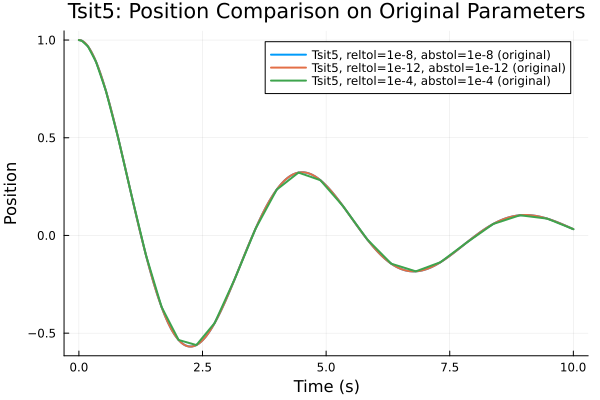

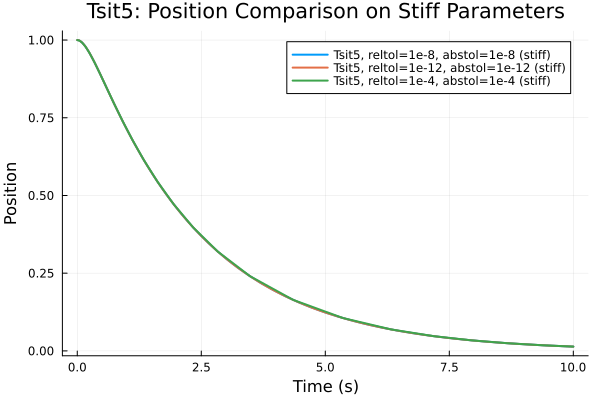

  0.025148 seconds (26.93 k allocations: 1.404 MiB, 98.15% compilation time: 100% of which was recompilation)
  0.001972 seconds (10.70 k allocations: 491.656 KiB)
  0.000201 seconds (479 allocations: 22.062 KiB)
  0.000420 seconds (1.16 k allocations: 53.656 KiB)
  0.000776 seconds (5.82 k allocations: 255.242 KiB)
  0.000144 seconds (388 allocations: 18.453 KiB)


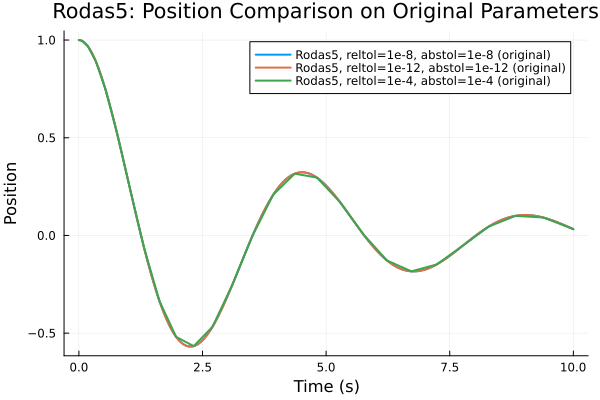

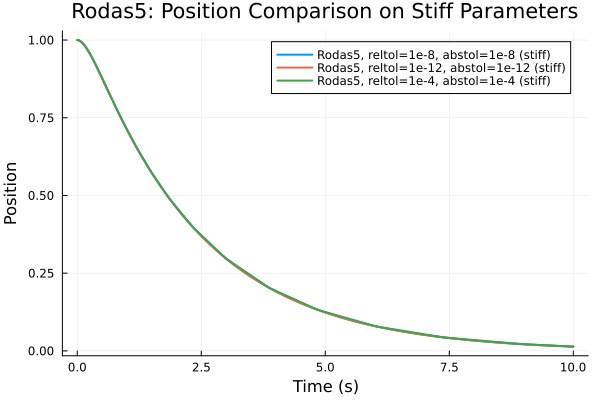

  0.020077 seconds (36.13 k allocations: 1.798 MiB, 96.79% compilation time: 100% of which was recompilation)
  0.002312 seconds (24.20 k allocations: 741.438 KiB)
  0.000326 seconds (1.80 k allocations: 57.141 KiB)
  0.000504 seconds (3.65 k allocations: 125.195 KiB)
  0.001311 seconds (13.93 k allocations: 454.828 KiB)
  0.000230 seconds (1.22 k allocations: 41.016 KiB)


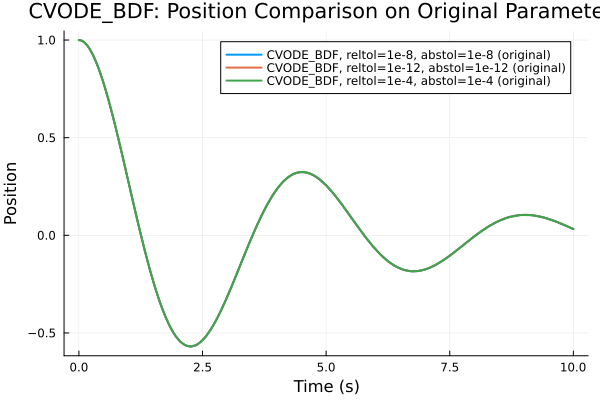

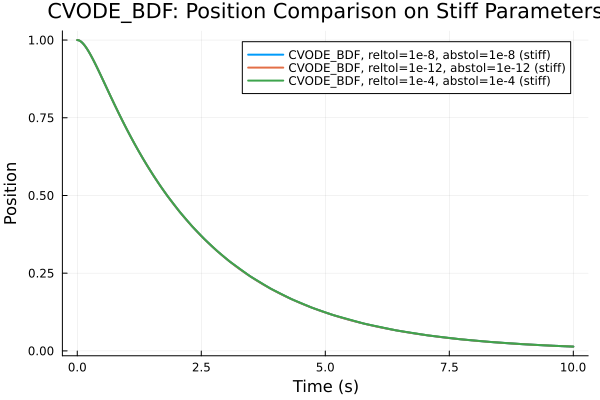

  0.705850 seconds (1.19 M allocations: 63.560 MiB, 2.94% gc time, 99.74% compilation time)
  0.000262 seconds (8.05 k allocations: 338.930 KiB)
  0.000293 seconds (8.05 k allocations: 338.930 KiB)
  0.000272 seconds (8.05 k allocations: 338.961 KiB)
  0.000252 seconds (8.05 k allocations: 338.961 KiB)
  0.000268 seconds (8.05 k allocations: 338.961 KiB)


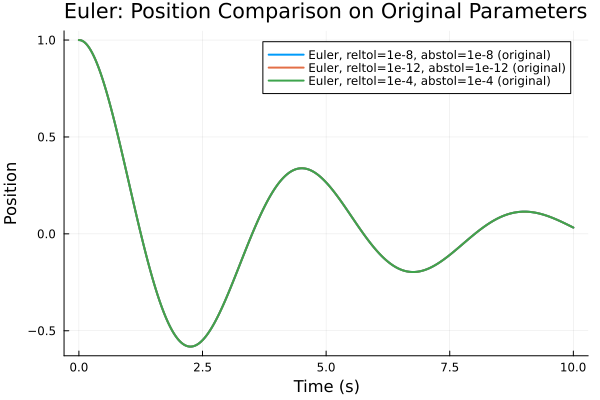

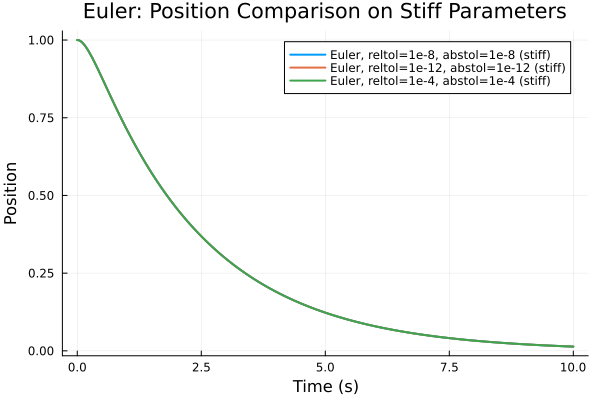

In [18]:
# Определение функции dynamics для двойного интегратора
function robot_dynamics!(du, u, p, t)
    du[1] = u[2]
    du[2] = -p[1]*u[1] - p[2]*u[2]
end

# Начальные условия
u0 = [1.0, 0.0]

# Интервал времени для моделирования
tspan = (0.0, 10.0)

# Параметры модели (коэффициент упругости и затухания)
# Исходные параметры
p = [2.0, 0.5]
# Параметры для более жёсткой модели (увеличим коэффициент затухания)
p_stiff = [2.0, 5.0]

# Создание задачи ОДУ для исходных параметров
prob = ODEProblem(robot_dynamics!, u0, tspan, p)
# Создание задачи ОДУ для более жёсткой модели
prob_stiff = ODEProblem(robot_dynamics!, u0, tspan, p_stiff)

# 1. Метод Tsit5
# Случай 1: стандартные параметры погрешности для исходных параметров модели
@time sol_Tsit5_original_1 = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)
# Случай 2: уменьшенные параметры погрешности для исходных параметров модели
@time sol_Tsit5_original_2 = solve(prob, Tsit5(), reltol=1e-12, abstol=1e-12)
# Случай 3: увеличенные параметры погрешности для исходных параметров модели
@time sol_Tsit5_original_3 = solve(prob, Tsit5(), reltol=1e-4, abstol=1e-4)

# Случай 1: стандартные параметры погрешности для жёсткой модели
@time sol_Tsit5_stiff_1 = solve(prob_stiff, Tsit5(), reltol=1e-8, abstol=1e-8)
# Случай 2: уменьшенные параметры погрешности для жёсткой модели
@time sol_Tsit5_stiff_2 = solve(prob_stiff, Tsit5(), reltol=1e-12, abstol=1e-12)
# Случай 3: увеличенные параметры погрешности для жёсткой модели
@time sol_Tsit5_stiff_3 = solve(prob_stiff, Tsit5(), reltol=1e-4, abstol=1e-4)

# Визуализация результатов для Tsit5 на исходных параметрах
using Plots
plot(sol_Tsit5_original_1.t, sol_Tsit5_original_1[1,:], label="Tsit5, reltol=1e-8, abstol=1e-8 (original)", xlabel="Time (s)", ylabel="Position", 
     title="Tsit5: Position Comparison on Original Parameters", lw=2)
plot!(sol_Tsit5_original_2.t, sol_Tsit5_original_2[1,:], label="Tsit5, reltol=1e-12, abstol=1e-12 (original)", lw=2)
plot!(sol_Tsit5_original_3.t, sol_Tsit5_original_3[1,:], label="Tsit5, reltol=1e-4, abstol=1e-4 (original)", lw=2)
display(current())

# Визуализация результатов для Tsit5 на жёстких параметрах
plot(sol_Tsit5_stiff_1.t, sol_Tsit5_stiff_1[1,:], label="Tsit5, reltol=1e-8, abstol=1e-8 (stiff)", xlabel="Time (s)", ylabel="Position", 
     title="Tsit5: Position Comparison on Stiff Parameters", lw=2)
plot!(sol_Tsit5_stiff_2.t, sol_Tsit5_stiff_2[1,:], label="Tsit5, reltol=1e-12, abstol=1e-12 (stiff)", lw=2)
plot!(sol_Tsit5_stiff_3.t, sol_Tsit5_stiff_3[1,:], label="Tsit5, reltol=1e-4, abstol=1e-4 (stiff)", lw=2)
display(current())

# 2. Метод Rodas5
# Случай 1: стандартные параметры погрешности для исходных параметров модели
@time sol_Rodas5_original_1 = solve(prob, Rodas5(), reltol=1e-8, abstol=1e-8)
# Случай 2: уменьшенные параметры погрешности для исходных параметров модели
@time sol_Rodas5_original_2 = solve(prob, Rodas5(), reltol=1e-12, abstol=1e-12)
# Случай 3: увеличенные параметры погрешности для исходных параметров модели
@time sol_Rodas5_original_3 = solve(prob, Rodas5(), reltol=1e-4, abstol=1e-4)

# Случай 1: стандартные параметры погрешности для жёсткой модели
@time sol_Rodas5_stiff_1 = solve(prob_stiff, Rodas5(), reltol=1e-8, abstol=1e-8)
# Случай 2: уменьшенные параметры погрешности для жёсткой модели
@time sol_Rodas5_stiff_2 = solve(prob_stiff, Rodas5(), reltol=1e-12, abstol=1e-12)
# Случай 3: увеличенные параметры погрешности для жёсткой модели
@time sol_Rodas5_stiff_3 = solve(prob_stiff, Rodas5(), reltol=1e-4, abstol=1e-4)

# Визуализация результатов для Rodas5 на исходных параметрах
plot(sol_Rodas5_original_1.t, sol_Rodas5_original_1[1,:], label="Rodas5, reltol=1e-8, abstol=1e-8 (original)", xlabel="Time (s)", ylabel="Position", 
     title="Rodas5: Position Comparison on Original Parameters", lw=2)
plot!(sol_Rodas5_original_2.t, sol_Rodas5_original_2[1,:], label="Rodas5, reltol=1e-12, abstol=1e-12 (original)", lw=2)
plot!(sol_Rodas5_original_3.t, sol_Rodas5_original_3[1,:], label="Rodas5, reltol=1e-4, abstol=1e-4 (original)", lw=2)
display(current())

# Визуализация результатов для Rodas5 на жёстких параметрах
plot(sol_Rodas5_stiff_1.t, sol_Rodas5_stiff_1[1,:], label="Rodas5, reltol=1e-8, abstol=1e-8 (stiff)", xlabel="Time (s)", ylabel="Position", 
     title="Rodas5: Position Comparison on Stiff Parameters", lw=2)
plot!(sol_Rodas5_stiff_2.t, sol_Rodas5_stiff_2[1,:], label="Rodas5, reltol=1e-12, abstol=1e-12 (stiff)", lw=2)
plot!(sol_Rodas5_stiff_3.t, sol_Rodas5_stiff_3[1,:], label="Rodas5, reltol=1e-4, abstol=1e-4 (stiff)", lw=2)
display(current())

# 3. Метод CVODE_BDF
# Случай 1: стандартные параметры погрешности для исходных параметров модели
@time sol_CVODE_original_1 = solve(prob, CVODE_BDF(), reltol=1e-8, abstol=1e-8)
# Случай 2: уменьшенные параметры погрешности для исходных параметров модели
@time sol_CVODE_original_2 = solve(prob, CVODE_BDF(), reltol=1e-12, abstol=1e-12)
# Случай 3: увеличенные параметры погрешности для исходных параметров модели
@time sol_CVODE_original_3 = solve(prob, CVODE_BDF(), reltol=1e-4, abstol=1e-4)

# Случай 1: стандартные параметры погрешности для жёсткой модели
@time sol_CVODE_stiff_1 = solve(prob_stiff, CVODE_BDF(), reltol=1e-8, abstol=1e-8)
# Случай 2: уменьшенные параметры погрешности для жёсткой модели
@time sol_CVODE_stiff_2 = solve(prob_stiff, CVODE_BDF(), reltol=1e-12, abstol=1e-12)
# Случай 3: увеличенные параметры погрешности для жёсткой модели
@time sol_CVODE_stiff_3 = solve(prob_stiff, CVODE_BDF(), reltol=1e-4, abstol=1e-4)

# Визуализация результатов для CVODE_BDF на исходных параметрах
plot(sol_CVODE_original_1.t, sol_CVODE_original_1[1,:], label="CVODE_BDF, reltol=1e-8, abstol=1e-8 (original)", xlabel="Time (s)", ylabel="Position", 
     title="CVODE_BDF: Position Comparison on Original Parameters", lw=2)
plot!(sol_CVODE_original_2.t, sol_CVODE_original_2[1,:], label="CVODE_BDF, reltol=1e-12, abstol=1e-12 (original)", lw=2)
plot!(sol_CVODE_original_3.t, sol_CVODE_original_3[1,:], label="CVODE_BDF, reltol=1e-4, abstol=1e-4 (original)", lw=2)
display(current())

# Визуализация результатов для CVODE_BDF на жёстких параметрах
plot(sol_CVODE_stiff_1.t, sol_CVODE_stiff_1[1,:], label="CVODE_BDF, reltol=1e-8, abstol=1e-8 (stiff)", xlabel="Time (s)", ylabel="Position", 
     title="CVODE_BDF: Position Comparison on Stiff Parameters", lw=2)
plot!(sol_CVODE_stiff_2.t, sol_CVODE_stiff_2[1,:], label="CVODE_BDF, reltol=1e-12, abstol=1e-12 (stiff)", lw=2)
plot!(sol_CVODE_stiff_3.t, sol_CVODE_stiff_3[1,:], label="CVODE_BDF, reltol=1e-4, abstol=1e-4 (stiff)", lw=2)
display(current())

# 4. Метод Эйлера
# Случай 1: стандартные параметры погрешности для исходных параметров модели с указанием dt
dt = 0.01
@time sol_Euler_original_1 = solve(prob, Euler(), reltol=1e-8, abstol=1e-8, dt = dt)
# Случай 2: уменьшенные параметры погрешности для исходных параметров модели с указанием dt
@time sol_Euler_original_2 = solve(prob, Euler(), reltol=1e-12, abstol=1e-12, dt = dt)
# Случай 3: увеличенные параметры погрешности для исходных параметров модели с указанием dt
@time sol_Euler_original_3 = solve(prob, Euler(), reltol=1e-4, abstol=1e-4, dt = dt)

# Случай 1: стандартные параметры погрешности для жёсткой модели с указанием dt
@time sol_Euler_stiff_1 = solve(prob_stiff, Euler(), reltol=1e-8, abstol=1e-8, dt = dt)
# Случай 2: уменьшенные параметры погрешности для жёсткой модели с указанием dt
@time sol_Euler_stiff_2 = solve(prob_stiff, Euler(), reltol=1e-12, abstol=1e-12, dt = dt)
# Случай 3: увеличенные параметры погрешности для жёсткой модели с указанием dt
@time sol_Euler_stiff_3 = solve(prob_stiff, Euler(), reltol=1e-4, abstol=1e-4, dt = dt)

# Визуализация результатов для Эйлера на исходных параметрах
plot(sol_Euler_original_1.t, sol_Euler_original_1[1,:], label="Euler, reltol=1e-8, abstol=1e-8 (original)", xlabel="Time (s)", ylabel="Position", 
     title="Euler: Position Comparison on Original Parameters", lw=2)
plot!(sol_Euler_original_2.t, sol_Euler_original_2[1,:], label="Euler, reltol=1e-12, abstol=1e-12 (original)", lw=2)
plot!(sol_Euler_original_3.t, sol_Euler_original_3[1,:], label="Euler, reltol=1e-4, abstol=1e-4 (original)", lw=2)
display(current())

# Визуализация результатов для Эйлера на жёстких параметрах
plot(sol_Euler_stiff_1.t, sol_Euler_stiff_1[1,:], label="Euler, reltol=1e-8, abstol=1e-8 (stiff)", xlabel="Time (s)", ylabel="Position", 
     title="Euler: Position Comparison on Stiff Parameters", lw=2)
plot!(sol_Euler_stiff_2.t, sol_Euler_stiff_2[1,:], label="Euler, reltol=1e-12, abstol=1e-12 (stiff)", lw=2)
plot!(sol_Euler_stiff_3.t, sol_Euler_stiff_3[1,:], label="Euler, reltol=1e-4, abstol=1e-4 (stiff)", lw=2)
display(current())

*ВАШ КОММЕНТАРИЙ ЗДЕСЬ* 

## Как выбор решателя влияет на решения для жёстких и нежёстких режимов:
Когда речь заходит о нежёстких режимах с низкими коэффициентами упругости и затухания, метод Эйлера может показать довольно неплохие результаты и при этом работать быстро. Особенно это актуально, когда требования к точности не слишком строгие. Это связано с тем, что в таких режимах изменения переменных происходят довольно плавно. Тем не менее, если нужна большая точность, то стоит рассмотреть более сложные методы, например Tsit5. У него есть адаптивный шаг интегрирования, что позволяет ему лучше справляться с колебаниями переменных.

Что касается жёстких режимов, где коэффициенты упругости и затухания высокие, то метод Эйлера становится неэффективным. Он может давать значительные расхождения и даже приводить к нестабильности. В таких случаях лучше использовать специальные методы, такие как Rodas5 и CVODE_BDF, так как они лучше подходят для быстроменяющихся переменных и обеспечивают более точное и стабильное решение.

## Компромиссы между временем вычислений, точностью и стабильностью:
Когда мы уменьшаем относительную (`reltol`) и абсолютную (`abstol`) погрешность, время выполнения решения увеличивается, так как методы морочатся и чаще проверяют сходимость. Например, в случае с Tsit5, если снизить `reltol` и `abstol` с 1e-8 до 1e-12, это замедляет решение из-за необходимости тонкой настройки шага. Увеличение погрешности, наоборот, позволяет получить решение быстрее, но точность при этом страдает.

Если говорить о стабильности, то низкие значения `reltol`и `abstol` обеспечивают более устойчивые результаты, особенно в жёстких системах, где малые ошибки могут сильно подпортить дело. Однако высокая точность может потребовать больше ресурсов и замедлить весь процесс.

В конечном счете, методы, которые предлагают большую стабильность, часто работают медленнее, как происходит с Rodas5 и CVODE_BDF по сравнению с методом Эйлера.

 # Дальше дополнительные задания и заключительный вопрос в самом конце.

## 4. Визуализация с MeshCat
При работе с роботами можно удобно визуализировать работу при помощи MeshCat (на сколько я поняла, к сожалению не получится использовать его с Binder, только локально). Но Вы можете попробовать её поднять на Binder, либо локально. 

In [25]:
using MeshCat
vis = Visualizer()

open(vis)
setobject!(vis, HyperSphere(Point(0.0, 0.0, 0.0), 0.5))

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8702


Could not open browser automatically: Base.IOError("could not spawn `xdg-open http://127.0.0.1:8702`: no such file or directory (ENOENT)", -2)
Please open the following URL in your browser:
http://127.0.0.1:8702


LoadError: UndefVarError: `HyperSphere` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing GeometryBasics in the current active module Main

## 5. Примеры TORA.jl для 2-DoF (двойного маятника)

DoF - степень свободы

В этом примере мы используем пакет **TORA.jl** для построения и моделирования модели двойного маятника.

Пример взят [отсюда](https://juliarobotics.org/RigidBodyDynamics.jl/dev/generated/1.%20Quickstart%20-%20double%20pendulum/1.%20Quickstart%20-%20double%20pendulum/#)

In [23]:
using RigidBodyDynamics
using SVector
using Plots

g = -9.81 # gravitational acceleration in z-direction
world = RigidBody{Float64}("world")
doublependulum = Mechanism(world; gravity = SVector(0, 0, g))

axis = SVector(0., 1., 0.) # joint axis
I_1 = 0.333 # moment of inertia about joint axis
c_1 = -0.5 # center of mass location with respect to joint axis
m_1 = 1. # mass
frame1 = CartesianFrame3D("upper_link") # the reference frame in which the spatial inertia will be expressed
inertia1 = SpatialInertia(frame1,
    moment=I_1 * axis * axis',
    com=SVector(0, 0, c_1),
    mass=m_1)

srcdir = dirname(pathof(RigidBodyDynamics))
urdf = joinpath(srcdir, "..", "test", "urdf", "Acrobot.urdf")
parse_urdf(urdf)


state = MechanismState(doublependulum)

set_configuration!(state, shoulder, 0.3)
set_configuration!(state, elbow, 0.4)
set_velocity!(state, shoulder, 1.)
set_velocity!(state, elbow, 2.);

q = configuration(state)
v = velocity(state)

transform(state, Point3D(frame_after(elbow), zero(SVector{3})),
    default_frame(world))

transform_to_root(state, frame_after(elbow))

relative_transform(state, frame_after(elbow), frame_after(shoulder))

center_of_mass(state)

mass_matrix(state)

v̇ = similar(velocity(state)) # the joint acceleration vector, i.e., the time derivative of the joint velocity vector v
v̇[shoulder][1] = 1
v̇[elbow][1] = 2
inverse_dynamics(state, v̇)

ts, qs, vs = simulate(state, 5., Δt = 1e-3);


LoadError: ArgumentError: Package SVector not found in current path.
- Run `import Pkg; Pkg.add("SVector")` to install the SVector package.

## 6. Свободные осциляции для 1-DoF и 2-DoF

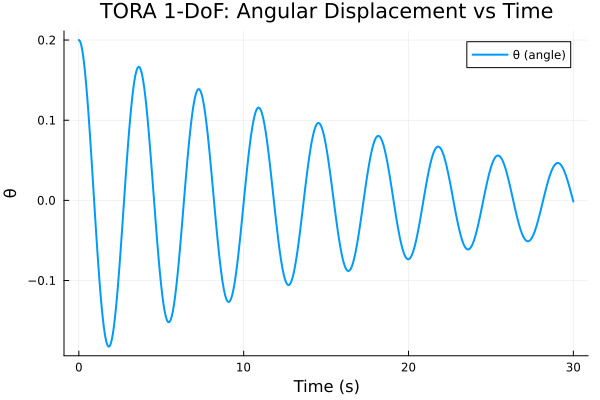

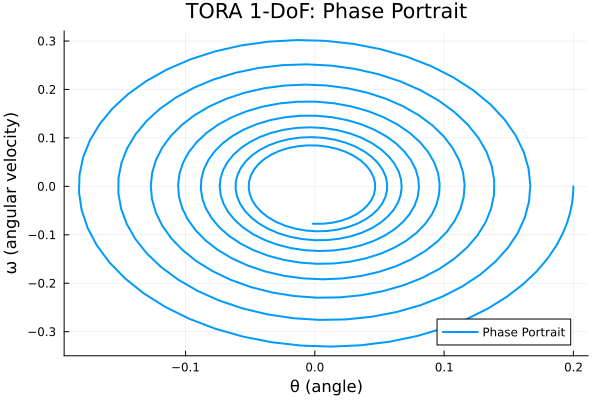

In [21]:
##############################
# TORA 1-DoF Model
##############################

# The ODE for a 1-DoF TORA system.
# Equation: θ'' + d θ' + c * sin(θ) = input, (we set input = 0 for free oscillation)
    function tora1dof!(du, u, p, t)
        d, c, input = p  # damping, stiffness, and external input torque
        theta, omega = u
        du[1] = omega
        du[2] = -d * omega - c * sin(theta) + input
    end
    
    # Initial condition: small initial displacement, starting from rest.
    u0_tora1 = [0.2, 0.0]
    # Time span: simulate over 30 seconds.
    tspan_tora1 = (0.0, 30.0)
    # Parameters: [damping, stiffness, input]. Set input = 0 for free oscillation.
    p_tora1 = [0.1, 3.0, 0.0]
    
    # Define and solve the ODE problem
    prob_tora1 = ODEProblem(tora1dof!, u0_tora1, tspan_tora1, p_tora1)
    sol_tora1 = solve(prob_tora1, Tsit5(), reltol=1e-8, abstol=1e-8)
    
    # Visualize the results:
    # (a) θ vs. Time
    plt1 = plot(sol_tora1.t, sol_tora1[1,:],
                label="θ (angle)",
                xlabel="Time (s)",
                ylabel="θ",
                title="TORA 1-DoF: Angular Displacement vs Time",
                lw=2)
    
    # (b) Phase Portrait: θ vs. ω
    plt2 = plot(sol_tora1[1,:], sol_tora1[2,:],
                label="Phase Portrait",
                xlabel="θ (angle)",
                ylabel="ω (angular velocity)",
                title="TORA 1-DoF: Phase Portrait",
                lw=2,
                legend=:bottomright)
    
    display(plt1)
    display(plt2)

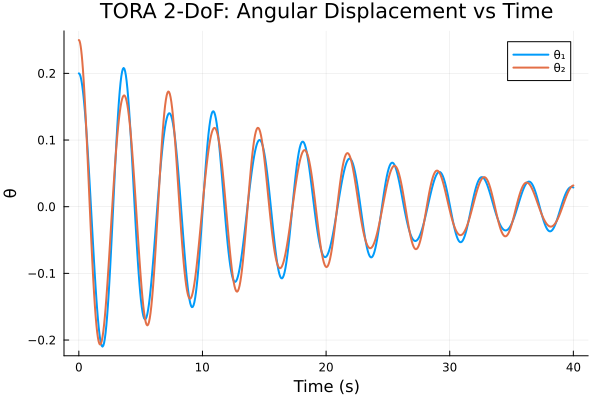

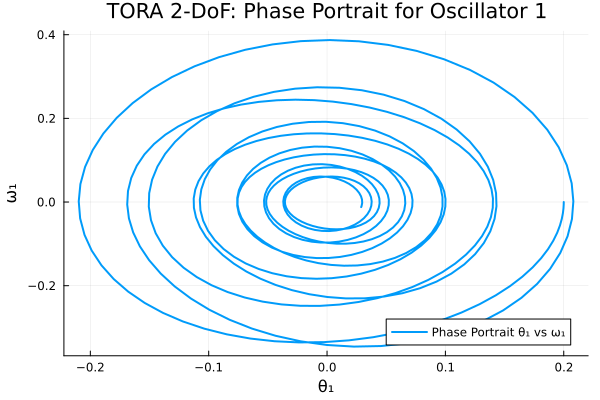

In [22]:
##############################
# TORA 2-DoF Model
##############################

# The ODE for a 2-DoF coupled TORA system.
# Equations:
# θ₁'' + d₁ θ₁' + c₁ sin(θ₁) + k*(θ₁ - θ₂) = input₁,
# θ₂'' + d₂ θ₂' + c₂ sin(θ₂) - k*(θ₁ - θ₂) = input₂.
function tora2dof!(du, u, p, t)
    # Unpack parameters:
    d1, c1, d2, c2, k, input1, input2 = p
    # Unpack state variables:
    theta1, theta2, omega1, omega2 = u
    du[1] = omega1
    du[2] = omega2
    du[3] = -d1 * omega1 - c1 * sin(theta1) + k*(theta2 - theta1) + input1
    du[4] = -d2 * omega2 - c2 * sin(theta2) - k*(theta2 - theta1) + input2
end

# Initial condition: small displacements and zero initial velocities.
u0_tora2 = [0.2, 0.25, 0.0, 0.0]
# Time span: simulate over 40 seconds.
tspan_tora2 = (0.0, 40.0)
# Parameters: [d1, c1, d2, c2, coupling stiffness k, input1, input2] (inputs are 0 for free oscillation).
p_tora2 = [0.1, 3.0, 0.1, 3.0, 2.0, 0.0, 0.0]

# Define and solve the ODE problem
prob_tora2 = ODEProblem(tora2dof!, u0_tora2, tspan_tora2, p_tora2)
sol_tora2 = solve(prob_tora2, Tsit5(), reltol=1e-8, abstol=1e-8)

# Visualize the results:
# (a) Angular displacement vs. Time for both angles
plt3 = plot(sol_tora2.t, sol_tora2[1,:],
            label="θ₁",
            xlabel="Time (s)",
            ylabel="θ",
            title="TORA 2-DoF: Angular Displacement vs Time",
            lw=2)
plot!(sol_tora2.t, sol_tora2[2,:], label="θ₂", lw=2)

# (b) Phase portrait for the first oscillator (θ₁ vs. ω₁)
plt4 = plot(sol_tora2[1,:], sol_tora2[3,:],
            label="Phase Portrait θ₁ vs ω₁",
            xlabel="θ₁",
            ylabel="ω₁",
            title="TORA 2-DoF: Phase Portrait for Oscillator 1",
            lw=2,
            legend=:bottomright)

display(plt3)
display(plt4)

## 6. Вопросы для обсуждения

1. Как различаются результаты у разных решателей?
2. Что происходит, когда вы уменьшаете или увеличиваете временной шаг для RK4?
3. Какой решатель кажется наиболее стабильным и точным для этого робота?
4. Попробуйте изменить начальное условие или длительность. Имеет ли большее значение выбор решателя для более длительных симуляций?



## 7. Бонус: Добавьте небольшое демпфирование (затухание) или измените параметры (необязательно)

Этот раздел можно расширить, чтобы изменить динамику (например, включить трение)., или интегрируйте с контроллером PD для стабилизации робота.

Вы можете добавить демпфирование, изменив правую часть ODE вручную,
или изменив параметры в определении механизма, если это поддерживается.
Пример:

In [ ]:
# function damped_dynamics!(du, u, p, t)
#     original_dynamics!(du, u, p, t)  # call base dynamics
#     damping_coeff = 0.1
#     du[2] -= damping_coeff * u[2]   # damping on θ̇₁
#     du[4] -= damping_coeff * u[4]   # damping on θ̇₂
# end

# prob_damped = ODEProblem(damped_dynamics!, u0, tspan)
# sol_damped = solve(prob_damped)

In [ ]:
# --- PD Control Stub Example ---
# Давайте установим его в нужное положение с помощью PD-контроллера.

# desired_angles = [0.0, 0.0]  # desired θ₁ and θ₂
# Kp = 10.0
# Kd = 2.0

# function controlled_dynamics!(du, u, p, t)
#     θ = u[1:2]
#     θ_dot = u[3:4]
#     τ = -Kp .* (θ .- desired_angles) - Kd .* θ_dot
#     # Apply τ to dynamics (requires manual dynamics or input support)
#     # Replace this with robot equations with control input if using extended model
#     original_dynamics!(du, u, p, t)
#     du[2] += τ[1]  # pseudo torque injection
#     du[4] += τ[2]
# end

# prob_controlled = ODEProblem(controlled_dynamics!, u0, tspan)
# sol_controlled = solve(prob_controlled)

# plot(sol_controlled, vars=(0, 1), title="θ₁ with PD control", label="θ₁")

## 8. Дальнейшее изучение

Когда вы освоитесь с этой моделью, рассмотрите возможность расширения ноутбука за счет:

- Моделирования многозвенной роботизированной руки, где вектор состояния включает в себя углы сочленений и угловые скорости.
- Включение управления с обратной связью (например, с помощью PID‑регулятора) в ОДУ для моделирования динамики замкнутого цикла.
- Изучение обработки событий (например, когда робот достигает цели или сталкивается с объектом) с использованием обратных вызовов в DifferentialEquations.jl.

## Дополнительные материалы
1. [Julia](https://julialang.org/) как язык программирования.
2. [Видео](https://www.youtube.com/watch?v=5uF3VqgjiVE) про использование Julia и библиотеки TORA.jl для оптимизации траектории движения робота.
3. [Видео](https://www.youtube.com/watch?v=_--fIr5ConA), рассказывающее про Juliet&Romeo - новый язык программирования на основе Julia для программирования роботов от компаний Cognibotics & Estun Automation.

4. [Туториал]() по TORA.jl.

---

## Заключение

На этом практическом занятии вы узнали, как настроить модель робототехники в Julia, решить ее с помощью нескольких решателей ODE и проанализировать влияние выбора решателя на поведение системы. Понимание этих различий важно при масштабировании задач для более сложных приложений робототехники.

Приятного программирования и изучения!

Что нового и интересного Вы узнали именно для себя? Что Вам было интересно?

*ВАШ КОММЕНТАРИЙ ЗДЕСЬ*

На этом практическом занятии я узнала много нового, особенно о робототехнике и решении обыкновенных дифференциальных уравнений (ОДУ) на языке Julia.

Во-первых, я научилась настраивать простую модель робота — двойной интегратор — в Julia. Также я разобралась с вектором состояния и динамикой задачи, что дало понимание моделирования движения робота.

Во-вторых, меня поразил огромный выбор решателей ОДУ в библиотеке DifferentialEquations.jl. Я ознакомилась с методами Tsit5, Rodas5 и CVODE_BDF. Применяя их к простой модели робота, я увидела, как может варьироваться результат в зависимости от метода. Tsit5 отлично справляется с не жёсткими системами, а Rodas5 и CVODE_BDF лучше подходят для жёстких задач.

Также я проанализировала, как параметры погрешности (`reltol` и `abstol`) влияют на точность и время выполнения. Я поняла, что их уменьшение увеличивает точность, но замедляет процесс. Это важно для разработки моделей в реальных приложениях, где нужно находить баланс между точностью и эффективностью.

Короче говоря, мне было интересно исследовать, как разные методы решения ОДУ влияют на моделирование робота. Это была очень интересная тема и я с удовольствием всё это делала =)